In [1]:
import pandas as pd
import numpy as np
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import shap

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['device','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['device','interaction_type','command'])

In [4]:
x_train, y_train = train.drop(columns=['global_category']), train['global_category']
x_test, y_test = test.drop(columns=['global_category']), test['global_category']

In [5]:
from sklearn.model_selection import ShuffleSplit

#Para no usar cross validation(Tarda mucho y ofrece peores resultados)
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

## Sin Hiperparámetros:

In [23]:
MLP = MLPClassifier(random_state=6) #Instanciamos

start = time.time()
MLP.fit(x_train, y_train)
stop = time.time()

#Guardamos la predicción de MLP
y_pred_MLP = MLP.predict(x_test)

#Matriz de confusión
cm_MLP = metrics.confusion_matrix(y_test, y_pred_MLP)

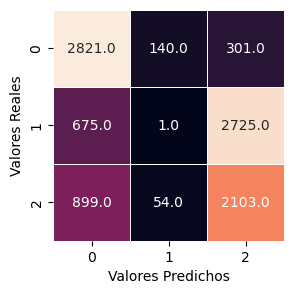

In [7]:
plt.figure(figsize=(3,3))
sns.heatmap(cm_MLP, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [8]:
print("Reporte del clasificador MLP: \n %s\n %s\n"
     %(MLP, metrics.classification_report(y_test, y_pred_MLP)))

Reporte del clasificador MLP: 
 MLPClassifier(random_state=5)
                  precision    recall  f1-score   support

          AUDIO       0.64      0.86      0.74      3262
         CAMERA       0.01      0.00      0.00      3401
HOME AUTOMATION       0.41      0.69      0.51      3056

       accuracy                           0.51      9719
      macro avg       0.35      0.52      0.42      9719
   weighted avg       0.35      0.51      0.41      9719




In [24]:
print(f"MLP training time: {stop - start}s")
print(f'Train accuracy : {MLP.score(x_train, y_train): .3f}')
print(f'Test accuracy : {MLP.score(x_test, y_test): .3f}')

MLP training time: 17.788689136505127s
Train accuracy :  1.000
Test accuracy :  0.623


## Con Hiperparámetros:

### Primera búsqueda:

In [24]:
param_grid1 = {'hidden_layer_sizes': [5], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

MLP_RandomGrid = RandomizedSearchCV(estimator = MLP,
                                    param_distributions = param_grid5, 
                                    cv = cv, verbose=2)

start = time.time()
MLP_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, solver=adam; total time=   1.9s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, solver=sgd; total time=   3.6s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, solver=adam; total time=   1.8s
[CV] END activation=logistic, hidden_layer_sizes=5, learning_rate=constant, solver=sgd; total time=   3.4s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, solver=sgd; total time=   4.5s


overflow encountered in matmul
overflow encountered in subtract
invalid value encountered in subtract
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, solver=sgd; total time=  10.7s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, solver=adam; total time=   2.9s


overflow encountered in matmul
overflow encountered in subtract
invalid value encountered in subtract
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=sgd; total time=  10.6s
[CV] END activation=logistic, hidden_layer_sizes=5, learning_rate=constant, solver=adam; total time=   1.9s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=adam; total time=   2.8s


In [25]:
print('Score: ', MLP_RandomGrid.best_score_)
print('Parameters: ', MLP_RandomGrid.best_params_)

Score:  0.8421052631578947
Parameters:  {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': 5, 'activation': 'identity'}


### Segunda búsqueda:

In [27]:
param_grid2 = {'hidden_layer_sizes': [5, 10, 15, (5,5), (5,10)], 
              'activation': ['identity'],
              'solver': ['adam'],
              'learning_rate': ['adaptive'],
              'random_state' : [int(x) for x in np.linspace(start=1, stop=20, num=20)],
              'max_iter': [int(x) for x in np.linspace(start=200, stop=800, num=30)]}

MLP_RandomGrid2 = RandomizedSearchCV(estimator = MLP,
                                    param_distributions = param_grid2, 
                                    cv = cv, verbose=2)

start = time.time()
MLP_RandomGrid2.fit(x_train, y_train)
stop = time.time()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] END activation=identity, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=696, random_state=7, solver=adam; total time=   2.4s
[CV] END activation=identity, hidden_layer_sizes=10, learning_rate=adaptive, max_iter=655, random_state=10, solver=adam; total time=   6.0s
[CV] END activation=identity, hidden_layer_sizes=15, learning_rate=adaptive, max_iter=324, random_state=2, solver=adam; total time=   3.6s
[CV] END activation=identity, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=655, random_state=4, solver=adam; total time=   4.4s
[CV] END activation=identity, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=510, random_state=4, solver=adam; total time=   4.4s
[CV] END activation=identity, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=220, random_state=4, solver=adam; total time=   5.9s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, max_iter=3

In [29]:
print('Score: ', MLP_RandomGrid2.best_score_)
print('Parameters: ', MLP_RandomGrid2.best_params_)

Score:  0.8430472153538208
Parameters:  {'solver': 'adam', 'random_state': 2, 'max_iter': 324, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 15, 'activation': 'identity'}


### Configuramos la Red neuronal

In [145]:
MLP2 = MLPClassifier(hidden_layer_sizes=15,
                    activation='identity', 
                    solver='adam',
                    learning_rate='adaptive',
                    random_state=8, 
                    max_iter = 500)

#8 -> 0.702 0.658


start = time.time()
MLP2.fit(x_train, y_train)
stop = time.time()

In [146]:
print(f"MLP training time: {stop - start}s")
print(f'Train accuracy : {MLP2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {MLP2.score(x_test, y_test): .3f}')

MLP training time: 6.389750719070435s
Train accuracy :  0.702
Test accuracy :  0.658


## Matriz de confusión:

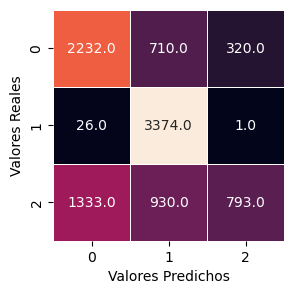

In [147]:
#Guardamos la predicción de MLP
y_pred_MLP2 = MLP2.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_MLP2)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [148]:
print("Reporte del clasificador MLP: \n %s\n %s\n"
     %(MLP2, metrics.classification_report(y_test, y_pred_MLP2)))

Reporte del clasificador MLP: 
 MLPClassifier(activation='identity', hidden_layer_sizes=15,
              learning_rate='adaptive', max_iter=500, random_state=8)
                  precision    recall  f1-score   support

          AUDIO       0.62      0.68      0.65      3262
         CAMERA       0.67      0.99      0.80      3401
HOME AUTOMATION       0.71      0.26      0.38      3056

       accuracy                           0.66      9719
      macro avg       0.67      0.65      0.61      9719
   weighted avg       0.67      0.66      0.62      9719


